### 基于Kmeans的文本聚类
github: https://github.com/cppccp/20news/

In [56]:
from glob import glob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
import base64

stopwords_set = set(stopwords.words('english'))
def remove_stopwords(words):  # 删除停用词
    words = [word for word in words if word not in stopwords_set]
    return words

def remove_digit_and_symbols(words):  # 只保留单词
    new_words = []
    for word in words:
        f = True
        for c in word:
            if c < 'A' or c > 'z' or (c < 'a' and c > 'Z'):
                f = False
                break
        if f:
            new_words.append(word)
    return new_words

files = glob('./20_newsgroups/*/*')
print(f'共有 {len(files)} 个文件')
# 文件数量太大，只选择2000个作为测试
import random
files = random.choices(files, k=2000)
print(f"选择{len(files)}作为测试")
articles = []
ground_labels = []
first_path = [path.split('/')[-1] for path in glob('./20_newsgroups/*')]
firstpath2id = {first_path[i]:i for i in range(len(first_path))}
for file in tqdm(files, total=len(files)):
    with open(file, 'r', encoding='utf-8') as f:
        article = f.read().lower()
        first_path = file.split('/')[-2]
        ground_labels.append(firstpath2id[first_path])
        words = word_tokenize(article)
        words = remove_stopwords(words)
        words = remove_digit_and_symbols(words)
        articles.append(words)

共有 19997 个文件
选择2000作为测试


100%|██████████| 2000/2000 [00:06<00:00, 322.04it/s]


In [57]:
# 统计所有的单词
from collections import Counter
from tqdm import tqdm
doc_counters = []
word2id = {}
wordsfreq = []
for doc in tqdm(articles, total=len(articles)):
    for word in doc:
        if word not in word2id.keys():
            word2id[word] = len(word2id)
            wordsfreq.append(0)
    counter = Counter(doc)
    for word in counter.keys():
        word_id = word2id[word]
        wordsfreq[word_id] += 1
    doc_counters.append(counter)
m = len(articles)
alpha = 0.4 * m
beta = 100
# 删除词频过低或过高的单词
new_word2id = {}

for word, word_id in word2id.items():
    if wordsfreq[word_id] <= alpha and wordsfreq[word_id] >= beta:
        new_word2id[word] = len(new_word2id)
new_freq = [0] * len(new_word2id)
for word, word_id in new_word2id.items():
    new_freq[word_id] = wordsfreq[word_id]
print(len(new_word2id))
word2id = new_word2id
wordsfreq = new_freq


100%|██████████| 2000/2000 [00:00<00:00, 11690.35it/s]

288


In [58]:
import math
X = []  # 所有文档的特征
m = len(articles)
vocab_size = len(word2id)
for counter, doc in tqdm(zip(doc_counters, articles),total=m):
    x = [0.] * vocab_size
    n = len(doc)
    for word in counter.keys():
        if word in word2id.keys():
            word_id = word2id[word]
            value = counter[word] / n * math.log(m / (1 + wordsfreq[word_id]))
            x[word_id] = value
    X.append(x)

100%|██████████| 2000/2000 [00:00<00:00, 21886.37it/s]


In [59]:
# 使用 kmeans 进行聚类
from sklearn.cluster import KMeans
import numpy as np
num_cluster = 20
kmeans = KMeans(num_cluster)
kmeans.fit(X)

KMeans(n_clusters=20)

In [60]:
from sklearn import metrics
score = metrics.calinski_harabasz_score(X, kmeans.labels_)
print(f"CH系数: {score}")

CH系数: 28.607379238616343


生成tsne降维...
tsne完成
绘制图形...


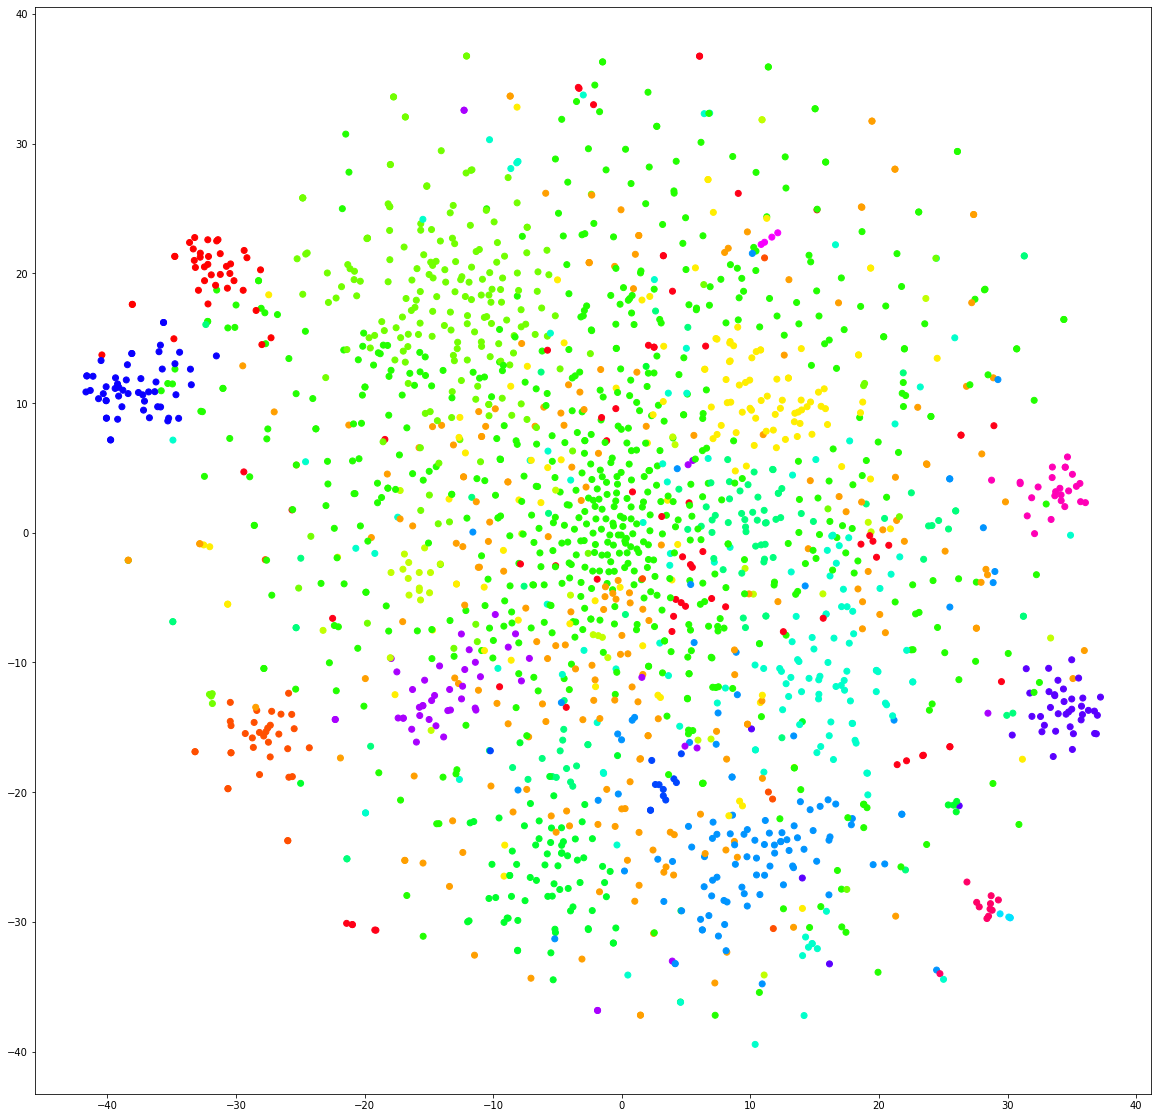

In [61]:
# 使用 tsnet 可视化
from sklearn import manifold
import matplotlib.pyplot as plt
colors = plt.cm.get_cmap('hsv', 20)
colors = colors(np.arange(20))
print("生成tsne降维...")
tsne = manifold.TSNE(2)
print("tsne完成")
x_tsne = tsne.fit_transform(X)
labels = kmeans.labels_
c = [colors[label] for label in labels]
# c = [colors[label] for label in ground_labels]
print("绘制图形...")
plt.figure(figsize=(20,20))
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=c)
plt.show()